# CNN Path Planning from Occupancy Grid
This notebook trains a CNN to predict optimal paths using A* auto-labeled data.

In [1]:
# !pip install torch torchvision matplotlib numpy tqdm

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import os
import heapq
from tqdm import tqdm

In [3]:
# A* Pathfinding
# This is a simple A* pathfinding implementation for a grid-based environment.
# The grid is represented as a 2D numpy array where 0 represents free space and 1 represents obstacles.
# The heuristic used is the Manhattan distance.
# The A* algorithm is implemented to find the shortest path from the start to the goal.
# The grid is generated randomly with a specified obstacle density.
# The start and goal positions are also randomly chosen.
# The grid size is fixed at 10x10 for simplicity.
# The A* algorithm is used to find the path from the start to the goal.

GRID_SIZE = 10

def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def reconstruct_path(came_from, current):
    path = [current]
    while current in came_from:
        current = came_from[current]
        path.append(current)
    path.reverse()
    return path

def a_star_find_path(grid, start, goal):
    neighbors = [(0, 1), (1, 0), (0, -1), (-1, 0)]
    close_set = set()
    came_from = {}
    gscore = {start: 0}
    fscore = {start: heuristic(start, goal)}
    open_set = []
    import heapq
    heapq.heappush(open_set, (fscore[start], start))
    while open_set:
        _, current = heapq.heappop(open_set)
        if current == goal:
            return reconstruct_path(came_from, current)
        close_set.add(current)
        for i, j in neighbors:
            neighbor = (current[0] + i, current[1] + j)
            if 0 <= neighbor[0] < GRID_SIZE and 0 <= neighbor[1] < GRID_SIZE:
                if grid[neighbor] == 1 or neighbor in close_set:
                    continue
                tentative_g = gscore[current] + 1
                if neighbor not in gscore or tentative_g < gscore[neighbor]:
                    came_from[neighbor] = current
                    gscore[neighbor] = tentative_g
                    fscore[neighbor] = tentative_g + heuristic(neighbor, goal)
                    heapq.heappush(open_set, (fscore[neighbor], neighbor))
    return []

def generate_valid_grid(obstacle_density=0.2):
    while True:
        grid = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
        start = (0, 0)
        goal = (np.random.randint(0, GRID_SIZE), np.random.randint(0, GRID_SIZE))
        while goal == start:
            goal = (np.random.randint(0, GRID_SIZE), np.random.randint(0, GRID_SIZE))
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                if (i, j) != start and (i, j) != goal and np.random.rand() < obstacle_density:
                    grid[i, j] = 1
        if a_star_find_path(grid, start, goal):
            return grid, start, goal

In [4]:
ReCreateDataset = False

DataSampleSize = 100000

if ReCreateDataset:
    os.makedirs("grid_dataset_colab", exist_ok=True)
    def save_sample(grid, path, index):
        sample = {"grid": grid, "path": np.array(path) if path else np.array([])}
        np.save(f"grid_dataset_colab/sample_{index}.npy", sample)
    for i in tqdm(range(DataSampleSize)):
        grid, start, goal = generate_valid_grid()
        path = a_star_find_path(grid, start, goal)
        save_sample(grid, path, i)

In [5]:
# Load the dataset

class GridPathDataset(Dataset):
    """A dataset class for loading grid and path samples.
    The dataset is expected to be in a directory containing .npy files.
    Each .npy file should contain a dictionary with keys "grid" and "path".
    The "grid" key should map to a 2D numpy array representing the grid,
    and the "path" key should map to a list of tuples representing the path.
    The dataset will load the grid and path from the .npy files and return them as PyTorch tensors.
    
    Args:
        data_dir (str): Directory containing the .npy files.
        max_files (int, optional): Maximum number of files to read. Defaults to None (read all files).
        
    Attributes:
        files (list): List of .npy file paths.
        
    Methods:
        __len__(): Returns the number of samples in the dataset.
        __getitem__(idx): Returns a sample at the specified index.
        
    Example:
        dataset = GridPathDataset("grid_dataset_colab", max_files=1000)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
        for grids, paths in dataloader:
            # Process the grids and paths
            pass
    """
    def __init__(self, data_dir, max_files=None):
        self.files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.npy')]
        if max_files is not None:
            self.files = self.files[:max_files]
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        sample = np.load(self.files[idx], allow_pickle=True).item()
        grid = sample["grid"].astype(np.float32)
        path = sample["path"]
        path = np.pad(path, ((0, max(0, 10 - len(path))), (0, 0)), mode='constant')[:10]
        
        # Add goal one-hot map as a second channel
        goal = tuple(path[np.nonzero(path.any(axis=1))[0][-1]])  # last non-zero waypoint
        goal_map = np.zeros_like(grid, dtype=np.float32)
        gx, gy = int(goal[0]), int(goal[1])
        if 0 <= gx < 10 and 0 <= gy < 10:
            goal_map[gx, gy] = 1.0

        multi_channel_input = np.stack([grid, goal_map])  # shape: (2, 10, 10)
        return torch.tensor(multi_channel_input), torch.tensor(path.flatten(), dtype=torch.float32)


In [6]:
# define the model as a class 
# The model is a simple CNN with two convolutional layers followed by three fully connected layers.
# The input to the model is a multi-channel grid representation, where the first channel represents the grid
# and the second channel represents the goal position.
# The output of the model is a flattened representation of the path.
# The model is trained using the Mean Squared Error (MSE) loss function.
class PathPlanningCNN(nn.Module):
    """
    _summary_: A simple CNN model for path planning.
    The model consists of two convolutional layers followed by three fully connected layers.
    The input to the model is a multi-channel grid representation, where the first channel represents the grid
    and the second channel represents the goal position.

    Args:
        nn (_type_): _description_
        
    Attributes:
        conv1 (nn.Conv2d): First convolutional layer.
        conv2 (nn.Conv2d): Second convolutional layer.
        pool (nn.MaxPool2d): Max pooling layer.
        fc1 (nn.Linear): First fully connected layer.
        fc2 (nn.Linear): Second fully connected layer.
        fc3 (nn.Linear): Third fully connected layer.
    Methods:
        forward(x): Forward pass through the model.
    
    Example:
        model = PathPlanningCNN()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.MSELoss()
        
        # Training loop
        for epoch in range(num_epochs):
            for grids, paths in dataloader:
                optimizer.zero_grad()
                outputs = model(grids)
                loss = criterion(outputs, paths)
                loss.backward()
                optimizer.step()
    
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 20)
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
#  Load the dataset
#  and split into train, validation, and test sets
MaxFiles = int(1e5) #10^5
dataset = GridPathDataset("grid_dataset_colab", MaxFiles)
train_len = int(0.8 * len(dataset))
val_len = int(0.1 * len(dataset))
test_len = len(dataset) - train_len - val_len
train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

#  Define the model, loss function, and optimizer
#  Use GPU if available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Initialize the model, loss function, and optimizer
#  Use Mean Squared Error loss and Adam optimizer
#  Set the learning rate to 0.001
model = PathPlanningCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
lambda_goal = 10
criterion = nn.MSELoss()
MaxNumEpochs = 10 # 10
def custom_loss(y_pred, y, lambda_goal, criterion):
    main_loss = criterion(y_pred, y)
    goal_loss = criterion(y_pred[:, -2:], y[:, -2:])
    total_loss = main_loss + lambda_goal * goal_loss
    return total_loss, main_loss, goal_loss

def evaluate(model, loader):
    model.eval()
    total_loss, total_mae = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss,_ ,_ = custom_loss(y_pred, y, lambda_goal, criterion)
            total_loss += loss.item()
            total_mae += torch.abs(y_pred - y).mean().item()
    return total_loss / len(loader), total_mae / len(loader)

#  Train the model for 10 epochs
#  Evaluate the model on the validation set after each epoch
#  Print the training and validation loss after each epoch
#  Save the model after training
train_losses = []
val_losses = []

for epoch in range(MaxNumEpochs):
    # training phase
    model.train()
    total_train_loss = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        # main_loss = criterion(pred, y)
        # goal_loss = criterion(pred[:, -2:], y[:, -2:])
        # loss = main_loss + lambda_goal* goal_loss
        loss,_ ,_ = custom_loss(y_pred, y, lambda_goal, criterion)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        
    train_loss = total_train_loss / len(train_loader)
    
    # validation phase
    val_loss, val_mae = evaluate(model, val_loader)
    
    # Record losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # print progress
    print(f"Epoch{epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val MAE: {val_mae:.4f}")
    


Epoch01 | Train Loss: 41.8577 | Val Loss: 14.8989 | Val MAE: 0.6688
Epoch02 | Train Loss: 11.1647 | Val Loss: 10.5364 | Val MAE: 0.5977
Epoch03 | Train Loss: 7.8702 | Val Loss: 7.9576 | Val MAE: 0.5799
Epoch04 | Train Loss: 6.0871 | Val Loss: 6.8377 | Val MAE: 0.5514
Epoch05 | Train Loss: 4.9500 | Val Loss: 5.1666 | Val MAE: 0.5214
Epoch06 | Train Loss: 3.9990 | Val Loss: 5.9685 | Val MAE: 0.5251
Epoch07 | Train Loss: 3.3110 | Val Loss: 4.9656 | Val MAE: 0.4888
Epoch08 | Train Loss: 2.4628 | Val Loss: 4.3064 | Val MAE: 0.4694
Epoch09 | Train Loss: 1.8712 | Val Loss: 4.4595 | Val MAE: 0.4580
Epoch10 | Train Loss: 1.3606 | Val Loss: 3.9293 | Val MAE: 0.4121


In [13]:
# Test the model

def plot_prediction(grid, true_path, pred_path, show_title=""):
    # grid = grid.squeeze().numpy()
    grid = grid[0].numpy()  # Instead of grid.squeeze().numpy()
    plt.figure(figsize=(5, 5))
    plt.imshow(grid, cmap="gray_r")

    # Ground-truth A* path
    true_path = true_path.reshape(-1, 2)
    true_path = true_path[~np.all(true_path == 0, axis=1)]
    if len(true_path) > 0:
        plt.plot(true_path[:,1], true_path[:,0], 'o-', label='A* Path', color='blue')
        plt.scatter(true_path[0,1], true_path[0,0], color='green', label='Start', zorder=5)
        plt.scatter(true_path[-1,1], true_path[-1,0], color='orange', label='Goal', zorder=5)

    # Predicted path
    pred_path = pred_path.reshape(-1, 2)
    plt.plot(pred_path[:,1], pred_path[:,0], 'x--', label='Predicted Path', color='red')

    plt.legend(loc='upper right')
    plt.grid(True)
    plt.xticks(range(10))
    plt.yticks(range(10))
    plt.gca().invert_yaxis()
    plt.title(show_title)
    plt.show()

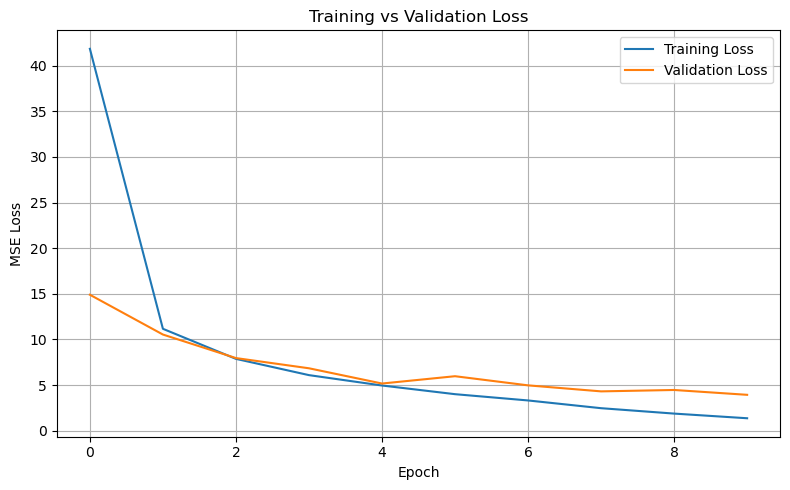

In [14]:
# Plot a tra
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Average Goal MSE (last waypoint only): 0.2799


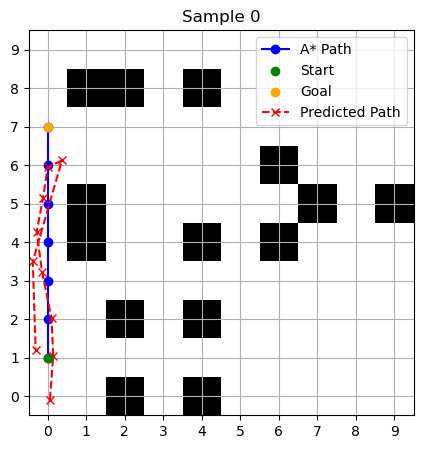

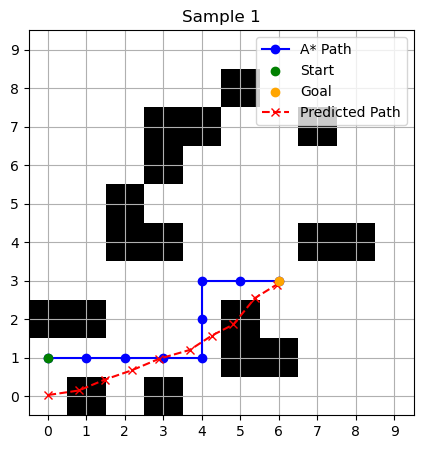

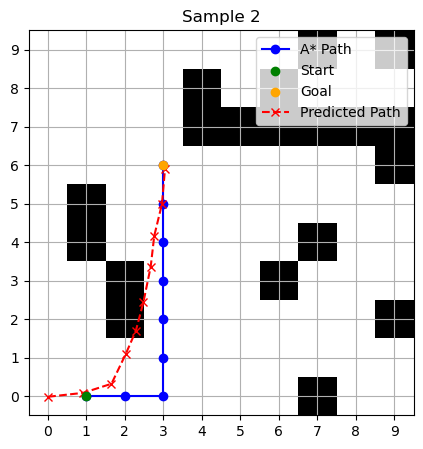

In [15]:
# Visualize Predictions
model.eval()
total_goal_loss = 0
total_samples = 0

with torch.no_grad():
    for x, y_true in test_loader:
        x, y_true = x.to(device), y_true.to(device)
        y_pred = model(x)

        _, _, goal_loss = custom_loss(y_pred, y_true, lambda_goal, criterion)

        batch_size = x.size(0)
        total_goal_loss += goal_loss.item() * batch_size
        total_samples += batch_size

avg_goal_loss = total_goal_loss / total_samples
print(f"Average Goal MSE (last waypoint only): {avg_goal_loss:.4f}")



# Print the first 3 examples from test data's first batch
with torch.no_grad():
    for x, y_true in test_loader:
        y_pred = model(x.to(device)).cpu().detach()        
        # Plot predictions for the first 3 samples in the batch
        for i in range(min(3, x.size(0))):  # Ensure we don't exceed batch size
            plot_prediction(x[i], y_true[i].numpy(), y_pred[i].numpy(), show_title=f"Sample {i}")
        break  # Only process the first batch
